In [1]:
__author__ = 'Michael Fitzpatrick <fitz@noao.edu>'
__version__ = '20201103'    # yyyymmdd; version datestamp of this notebook
__datasets__ = ['sdss_dr8','sdss_dr9','sdss_dr10','sdss_dr11','sdss_dr12', 'sdss_dr13','sdss_dr14','sdss_dr15','sdss_dr16']
__keywords__ = ['HowTo','spectra','query','vospace','mydb','SDSS']

# How to use the Spectrum Data Services

### Table of contents
* [Summary](#summary)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#imports)
* [Authentication](#auth)
* [Service URLs and Profiles](#profiles)
* [Dataset Contexts and Catalogs](#contexts)
* [Query for Spectra](#query)
    * [Using Alternate Catalogs](#alt_cats)
    * [Constraining query results](#constrain)
    * [Output Options](#out_opts)
* [Retrieving Data](#getdata)
    * [Spectrum Identifier / Templates](#identifiers)
    * [Single-spectrum access](#ssa)
    * [Multi-spectrum access](#msa)
    * [Context-specific data](#context)
    * [Data Caching and Performance](#performance)
* [Visualization](#viz)
    * [Static plot display](#static_plot)
    * [Preview plots](#preview_plot)
    * [Grid preview plots](#grid_plot)
    * [Stacked image display](#stacked_image)
* [Utility Methods](#utility)


<a class="anchor" id="summary"></a>
# Summary

This notebook documents how to query, retrieve and visualize spectra from the NOIRLab spectral data service. For full documentation see the <a href="https://datalab.noao.edu/docs/api/specClient.html">API documentation</a>.


### The *specClient* class


The specClient API provides the following interface methods:

          client = getClient (context='<context>', profile='<profile>')

            status = isAlive (svc_url=DEF_SERVICE_URL, timeout=2)

                 set_svc_url (svc_url)
       svc_url = get_svc_url ()

                 set_context (context)
           ctx = get_context ()
        ctxs = list_contexts ([optval,] token=None, contexts=None, fmt='text')

                 set_profile (profile)
          prof = get_profile ()
       profs = list_profiles ([optval,] token=None, profile=None, fmt='text')
       
                    catalogs (context='default', profile='default', fmt='text')

    QUERY INTERFACE:
             id_list = query (<region> | <coord, size> | <ra, dec, size>,
                              constraint=<sql_where_clause>,
                              context='default', profile='default', **kw)
                             
                              Returns: an array of identifiers matching the query

    DATA ACCESS INTERFACE:
       spec | list = getSpec (<id> | <id_list>, fmt='numpy',
                              out=None, align=False, cutout=None,
                              context='default', profile='default', **kw)
                             
                              Returns: a spectrum object of the requested type if
                                       given a singe <id>, or an array of those
                                       objects if given an <id_list>

    PLOT  INTERFACE:
                        plot (<id> | <spec>, context=context, profile=profile, **kw)
         png_image = preview (<id> | <id_list>, context=context, profile=profile, **kw)
        png_image = plotGrid (id_list, nx, ny, page=<N>,
                              context=context, profile=profile, **kw)
    png_image = stackedImage (<id_list>, fmt='png|numpy',
                              align=False, yflip=False,
                              context=context, profile=profile, **kw)
                              
    UTILITY METHODS:
                   to_pandas (numpy_array)
                    to_table (numpy_array)
                to_Specrum1D (numpy_array)

                     
#### Spectrum Identifiers, Contexts and Lists
Spectrum identifiers are specific to the dataset `context`, i.e. SDSS spectra might be uniquely identifiable as a 64-bit '*specobjid*' value or as a tuple of (*plate,mjd,fiber,run2d*) values, but other datasets are free to use other types of identifiers peculiar to those data.  An *id* (or an array of *id*, known as an *id_list*) can be any form of integer/tuple/string and is passed transparently to the backend services.  The '*context*' parameter can be set explicitly with each call (or globally with the `set_context(<ctx>)` method) and the service will use that information to interpret the idenitfier for the dataset.

When a service such as `getSpec()` is given a single *id* object, it will return a single result of the requested type.  Likewise, if given a list of identifiers, the method will return a list of objects  of the requested type.

#### Input and Output Formats
The result of a `query()` call is always an array of spectrum identifiers which can be passed directly to the 'getSpec()' method to retrieve the data.  If the identifier list is generated in some other way (e.g. a separate query, read from a file, etc) it must be converted to an array first before being used to retrieve data.  The `getSpec()` method will also accept a filename (either local or a virtual storage 'vos://' path) and will read the file assuming there is one identifier per line in the file.
    
Spectra retrieved from 'getSpec()' will be in one of the supported formats and will contain at least the following four bands:
                loglam     the log-lambda wavelength array
                flux       the flux array
                sky        sky spectrum (not supported by all datasets)
                ivar       the inverse variance array

Note these names are specific to the `specCLient` interface and may map to different names in the dataset itself. Additional information may be present depending on the dataset being queried.

#### Saving Results
If no save location is specified (no *out* param) then the results are returned directly. A save location beginning with the 'vos://' identifier indicates a location in the user's virtual storage to save the result. 

### From Python code

[NOTE: Not Yet Implemented as of this writing]

The spectrum client service can be called from Python code using the *datalab* module. This provides methods to access the various query client functions in the *specClient* subpackage. See the information [here](https://github.com/noaodatalab/datalab/blob/master/README.md).

Spectrum commands can be also run from the command line, e.g. on your local machine, using the datalab command line utility. Read about it in our GitHub repo [here](https://github.com/noaodatalab/datalab).


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noao.edu/disclaimers.php

<a class="anchor" id="imports"></a>

---
# Imports and setup

This is the setup that is required to demonstrate the spectrum services client in this notebook. Whether any particular import is required will depend on your usage.

The first thing to do is import the relevant Python modules.

In [2]:
# Standard libs
from getpass import getpass               # for password prompts

import os
import time
import numpy as np                        # for manipulating arrays
import pandas as pd
from specutils import Spectrum1D

from io import BytesIO
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.coordinates import SkyCoord
from IPython.display import Image, display

from matplotlib import pyplot as plt      # visualization libs
%matplotlib inline

# Data Lab imports
#from dl import specClient as spec
import specClient as spec                 # if using the specClient.py file directly
spec.set_svc_url('http://gp07.datalab.noao.edu:6998/spec')

from dl import storeClient
from dl import queryClient
from dl import authClient
from dl.helpers.utils import convert

start_time = time.time()

In [3]:
# Global vars for test data
svc_base = "http://datalab.noao.edu/spec"

# Default test single-spectrum
context  = 'sdss_dr16'
specobjid = 2210146812474530816
plate, mjd, fiber, run2d = 1963, 54331, 19, 103
bands    = 'flux,loglam,model,ivar'

# Local laptop test data (15,360 files)
# RUN2D = 103, 22 plates/mjd, 640 fibers each
plates = [1960, 1961, 1962, 1963, 2078, 2079, 2174, 2185, 2247, 2255, 2256, 
          2333, 2338, 2377, 2475, 2476, 2667, 2671, 2800, 2821, 2887, 2912]
mjd = [53289, 53299, 53321, 54331, 53378, 53379, 53521, 53532, 53857,
       54169, 53565, 53859, 53682, 53683, 53991, 53845, 53826, 54142,
       54141, 54326, 54393, 54495, 54521, 54499]
plt_mjd = list(zip(plates,mjd))

<a class="anchor" id="auth"></a>

---
# Authentication
Much of the functionality of spectrum services can be accessed without explicitly logging into Data Lab (the service then uses an anonymous login). But some capabilities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, uncomment the `ac.login()` command and respond according to the prompts.  If you have previously logged into Data Lab, this cell will simply print your active user name.

In [4]:
#authClient.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
authClient.whoAmI()

'fitz'

<a class="anchor" id="profiles"></a>

---
# Service URLs and Profiles

The service URL can be changed when needed, e.g. to point to a development service or a local service instance.

In [5]:
# Get the current service URL
svc_url = spec.get_svc_url()
print ('Current ServiceURL:  ' + svc_url)

status = spec.set_svc_url(svc_url)      # Set the ServiceURL

Current ServiceURL:  http://gp07.datalab.noao.edu:6998/spec


Service *profiles* are configuration settings in the service that make use of alternate backends or which provide access to specific data sets.  These may be set in the service interface to apply to all method calls, or can be passed explicitly using '*profile*' parameter.

In [6]:
profile = spec.get_profile()         # Get the current profile
print('Current profile: ' + profile)

status = spec.set_profile(profile)   # Reset the current profile
print (spec.list_profiles())         # List the available service profiles

Current profile: default
         default   Default service
           dldev   DEV Spectrum Service (Not-yet-implemented)
          dltest   TEST Spectrum Service (Not-yet-implemented)
       localhost   All-Local Spectrum Service



<a class="anchor" id="contexts"></a>

---
# Dataset Contexts and Catalogs

The initial release of the spectral service include only SDSS coadded spectra from the BOSS/eBOSS/SDSS surveys.  The DR16 data is served from a pre-computed cache to optimize performance, however *all* data releases are available even if they might not be as performant due to data-conversion overhead. Accessing a specific data release is a matter of defining the *dataset context* via the '*context*' parameter to each method or globally using the `set_context()` method.  Contexts are strings of the form

                <survey>_<release>

This name generally matches the schema names used by other Data Lab services. The *default* context as of this writing is '*sdss_dr16*', indicating the SDSS DR16 spectra. As new datasets are added, other contexts will likewise be added that implement the specific details (e.g. storage location, data format, etc) of services for each dataset. Additional information of using contexts is discussed below.

Although not explicitly required, the context can be set for the interface once at the beginning of a sessions and it will apply to all calls unless overridden by an explicit '*context*' parameter.  For example,

In [7]:
# Set the interface data context
status = spec.set_context('default')              # use the default (SDSS DR16) context
status = spec.set_context('sdss_dr16')            # same as above
print(status)
print ('Current context: ' + spec.get_context())  # print the currently active context name

print (spec.list_contexts())                      # print a list of available contexts

OK
Current context: default
         default   Default data context (default: 'sdss_dr16')
       sdss_dr16   SDSS DR16 coadded spectra from BOSS/eBOSS/SDSS (cached)
       sdss_dr15   SDSS DR15 coadded spectra from BOSS/eBOSS/SDSS
       sdss_dr14   SDSS DR14 coadded spectra from BOSS/eBOSS/SDSS
       sdss_dr13   SDSS DR13 coadded spectra from BOSS/eBOSS/SDSS
       sdss_dr12   SDSS DR12 coadded spectra from BOSS/SDSS
       sdss_dr11   SDSS DR11 coadded spectra from SDSS
       sdss_dr10   SDSS DR10 coadded spectra from SDSS
        sdss_dr9   SDSS DR9 coadded spectra from SDSS
        sdss_dr8   SDSS DR8 coadded spectra from SDSS



The data context also defines a default catalog to be used by the `query()` method in the interface, however there may be multiple catalogs available within Data Lab that suffice to provide needed identifiers.  The `query()` method contains a 'catalog' parameter that let's you override the default table being queried (e.g. to query a specific Value-Added Catalog), the `catalogs()` method can be used to list available catalogs for a given context:

In [8]:
catalogs = spec.catalogs(context='sdss_dr15')
print(catalogs)

Catalogs used by 'sdss_dr15' context:

               sdss_dr14.dr14q   SDSS DR14 Quasar Catalog
    sdss_dr16.sdssebossfirefly   eBOSS Firefly Value-added Catalog
    sdss_dr16.segue1specobjall   SDSS DR14 spectra - Segue-1 survey
    sdss_dr16.segue2specobjall   SDSS primary spectra - Segue-2 survey
     sdss_dr16.seguespecobjall   SDSS primary spectra - All Segue survey
             sdss_dr16.specobj   SDSS primary spectra (cleaned table)
          sdss_dr16.specobjall   SDSS primary spectra (may contain duplicates)



<a class="anchor" id="query"></a>

---
# Query for Spectra

The first step is to generate a list of spectrum identifiers you wish to retrieve from the service.  The interface provides a `specClient.query()` method to do this using various position-based queries, however the identifier list can just as easily be created by any other query of Data Lab tables.  

The *query()* may be called as:

            id_list = query (<region> | <coord, size> | <ra, dec, size>,
                             constraint=<sql_where_clause>,
                             context=None, profile=None, **kw)
                             
                where:
                    region      Array of polygon vertex tuples (in deg)
                    coord       Astropy Coord object
                    ra, dec     RA/Dec position (in deg)
                    size        Search size (in deg)
                    out         Save query results to filename
                    constraint  A valid SQL 'where' clause
                    context     Dataset context
                    profile     Service profile
                    kw          optional parameters

                returns:
                    An array of object identifiers for the given context. The
                    id types will be specific to the dataset and selected by
                    a 'fields' kw param or from a specific table, e.g. for 

                kw options:
                    for context='sdss_dr16':
                        fields:
                            specobjid           # or 'bestobjid', etc             (Default)
                            tuple               # a plate/mjd/fiber/run2d tuple   (Not Yet Implemented)
                        primary:
                            True                # query sdss_dr16.specobj
                            False               # query sdss_dr16.specobjall
                        catalog:
                            <schema>.<table>    # alternative catalog to query

                    for all contexts/profiles:
                        timeout=<timeout>       # query timeout
                        token=<token>           # to pass alternate auth token
                        debug                   # client debug flag
                        verbose                 # client verbosity flag

The only requirement is that an identifier be either a single object (e.g. an integer, tuple, string, etc), or an array of such objects. Depending on the data context, identifiers may also be specified in a way that implies multiple spectra are to be retrieved, e.g. to get all fibers on an SDSS plate without requiring the list of fiber numbers be created explicitly.

### Example 1)  Find spectra in a cone around a specific (RA,Dec) position:

The *query()* method can be called by passing the RA, Dec and a search radius (all in decimal degrees).  Print the resulting array to the screen by specifying a null *out* parameter.

In [9]:
# RA/Dec query
id_list = spec.query(30.0, 1.0, 0.025, out='')
print (str(id_list))

[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]


The result in this case is a 1-D array of SDSS *specobjid* identifiers.

### Example 2)  Find spectra using an Astropy *SkyCoord* object to specify position.  

The *SkyCoord* can be instantiated in a number of ways, however the search size must still be specified in decimal degrees.

In [10]:
# Astropy SkyCoord objects can be created in a number of ways:
posn = [ SkyCoord(ra=30.0*u.degree, dec=1.0*u.degree, frame='icrs'),   # explicit RA,Dec using astropy units
         SkyCoord(ra=30.0, dec=1.0, frame='icrs', unit='deg'),         # explicit RA,Dec position
         SkyCoord('2h0m0.0s +1d0m0s', frame='icrs')                    # sexagesimal position
       ]

for p in posn:
    print(spec.query(p, 0.025))
    print('-------')

[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------
[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------
[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------


Here, for each of the *SkyCoord* objects (all representing the same position) we print the 1-D array of identifiers.

### Example 3)  Find spectra within a polygonal region of the sky.

An array containing the vertices of a polygon (specified in decimal degrees) may be use to search for spectra.  The polygon is specified as a 1-D array with successive pairs of (ra,dec) values defining each vertex of the polygon and the last vertex does not need to be the same as the first to close the polygon.

In [11]:
# Region query
region = [29.95,0.95, 30.05,0.95, 30.05,1.05, 29.95,1.05]
print(spec.query(region, context='sdss',out=''))

[8822599620880519168 1694626468820183040 8255302463378444288
 1210486485086660608 1210489508743636992 3226968571238180864
 1750919545821882368 1750917896554440704 3226968021482366976
 1750920370455603200 4767234020315779072 1750921744845137920
  789367746562385920 1750921195089324032  453893824498919424]


<a class="anchor" id="alt_cats"></a>

## Using alternate catalogs

The '*catalog*' parameter can be used to query alternate catalogs available for a given dataset context.  Note that in this example the output identifier list differs from the same positional query used above.  The name of the table to use is *not* limited to those tables listed for the context, any table within Data Lab may be used but we cannot guarantee an identifier will always be correct for the dataset (e.g. earlier SDSS data releases have differing 'specobjid' values). 

By default, and since SDSS is the only dataset at the moment, the *specobjid* value is what is used as the unique identifier in the catalog.  If another identifier is desired, the *fields* parameter can be set but note that the data access method likely won't be able to resolve it to spectral data unless it is a recognized spectral identifier.

In [12]:
# RA/Dec query
id_list = spec.query(30.0, 1.0, 0.025, out='', catalog='sdss_dr16.sdssebossfirefly')
print (str(id_list))

[1210489508743636992 1750917896554440704 2325105415127328768
 3226968021482366976 1750920370455603200]


<a class="anchor" id="constrain"></a>

## Constraining query results

The '*constraint*' parameter can be specified as a valid SQL '*where*' clause to further constrain the result.  For example, to select above a certain redshift value and sort the results accordingly.

Note the '*constraint*' is appended to the query submitted by the database directly and so any quoted values must use single-quotes.

In [13]:
# Constraint tests
print(spec.query(30.0,1.0,0.05, out='',
                 constraint='z > 0.2 order by z limit 10'))

[1750919545821882368 4767234020315779072 1750921744845137920
 3226968571238180864  789367746562385920]


As you can see, the results are different than for the same position used above.

<a class="anchor" id="out_opts"></a>

## Output Options

Normally, *query()* results are returned to the caller as a list object identifiers (even when only one object is found).  However, the ID list may be saved as a text file for later use by setting the *out* parameter to be a local filename or a virtual storage location.  In that case, identifiers are saved one-per-row and the *query()* method returns either 'OK' or an error message.

### Example 1)  Return output to caller

In [14]:
id_list = spec.query(30.0,1.0,0.025, out='')  # return output to the caller
print(id_list)

[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]


### Example 2)  Save list to local file

In [15]:
fname = '/tmp/test.id'
print(spec.query(30.0,1.0,0.05, out=fname))   # Save result to a local file

status = 'SUCCESS' if os.path.exists(fname) else 'FAILED'
print('Local file:  %s' % status)
os.remove(fname)

OK
Local file:  SUCCESS


### Example 3)  Save list to virtual storage

In [16]:
fname = 'vos://test.id'
print(spec.query(30.0,1.0,0.05, out=fname))   # Save results to virtual storage

status = 'SUCCESS' if storeClient.access(fname) else 'FAILED'
print('VOS file:  %s' % status)
junk = storeClient.rm(fname)

OK
VOS file:  SUCCESS


<a class="anchor" id="getdata"></a>

---
# Retrieving Spectra

Data can be retrieved from the service using the `getSpec()` method.  The only required argument is either a single identifier object, or an array of those objects to return multiple spectra.  When given a single identifier a single spectrum in the requested output format is returned; when given an array of identifiers and array of those objects is returned. 

The `getSpec()` method may be called as:


            list = getSpec  (id_list, fmt='numpy',
                             out=None, align=False, cutout=None,
                             context=None, profile=None,
                             **kw)
                where:
                    id_list     List of object IDs (dataset-specific).
                                Must be one of:
                                    - single string/int/int64/tuple identifier
                                    - python array/list object
                                    - string of identifier values (one/line)
                                    - filename containing identifiers (one/line)
                                    - VOS name containing identifiers (one/line)
                    fmt         Result format, one of:
                                    numpy
                                    pandas
                                    Spectrum1D
                                    Spectrum1DCollection
                                    Spectrum1DList
                                    FITS
                    out         Output file location (fmt=FITS)
                    align       Align spectra to common wavelength grid
                    cutout      Cutout range as '<start>-<end>'
                    context     Dataset context
                    profile     Service profile
                    kw          optional parameters

                returns:
                    An array of data objects in the requested format, or a
                    single object of the requested type when the ID list is
                    not an array.  If the 'out' parameter is specified data
                    are saved to the specified directory and an 'OK' string
                    is returned, or progress output in verbose=True.

Supported output formats currently include:

                   numpy                A Numpy array
                   pandas               A Pandas DataFrame
                   Spectrum1d           A 'specutils' Spectrum1D object
                   SpectrumCollection   A 'specutils' SpectrumCollection object
                   table                An Astropy Table
                   FITS                 The original FITS file
                   
Each format contains a 'loglam', 'flux', 'sky', and 'ivar' vector although certain dataset may contain additional information.

The 'align' parameter can be enabled to return all spectra on a common wavelength grid by padding each spectrum as needed to fill the range of wavelengths between the global min/max wavelength of all spectra in the identifier list.  Spectra are *not* interpolated, rather it is assumed for this option that all spectra in the dataset share a common dispersion (usually in log wavelength space).  The 'cutout' parameter can be specified as a wavelength range (e.g. '4500-4750') to return arrays trimmed to that range (the 'align' parameter is implied in this case).  Similarly, the 'bands' parameter can be specified as a command delimited list of bands to return instead of all available data (e.g. bands='loglam,flux' to get just wavelength and flux arrays.

The 'out' parameter can be used to save spectra to a directory (either local or in a virtual space), but is only useful when retrieving FITS files.  In this case, the spectrum file associated with each identified is saved to the named directory.

In [17]:
# Utility routine to print information about a spectrum object.
def info(data):
    try:
        print(' Type: ' + str(type(data)))
        print('  Len: ' + str(len(data)))
        print('Shape: ' + str(data.shape))
        if isinstance(data,list) or isinstance(data,np.ndarray):
            print ('Element Type: ' + str(type(data[0])))
    except Exception as e:
        print(e)
        pass
    print('-----------')

<a class="anchor" id="identifiers"></a>

## Spectrum Identifier / Templates

In some use cases, generating a list of identifiers requires something other than a positional query, e.g. you wish to retrieve all fibers for a particular SDSS plate observation.  This *could* be generated with a manual query using the *queryClient* interface to query the catalog directly, but that is extra work when common usage of the data allows a shorthand.  For example, in SDSS a single object spectrum can be identified by a *(plate,mjd,fiber)* tuple, but it is commonly understood that *(plate,mjd)* refers to all fibers on the plate.  What we'd like to be able to do in that case is recognize the shortcut and internally generate the list.  Note that this is permitted since the identifiers are opaque to the client and are resolved by the service depending on the context.

In that example, we can specify the identifier list as follows:

In [18]:
#id_list = [(1963,54331,1),(1963,54331,2), .......]       # specify each fiber individually
id_list = [(1963,54331)]                                  # give plate/mjd only, fibers expanded internally
id_list = [(1963,54331,'*')]                              # use a metachar as a placeholder

data = spec.getSpec(id_list, fmt='numpy', align=False)
info(data)

 Type: <class 'numpy.ndarray'>
  Len: 618
Shape: (618, 3858)
Element Type: <class 'numpy.ndarray'>
-----------


In the example above the '\*' metachar could also be used in place of the 'plate' or 'mjd' field in the tuple (e.g. "get all spectra from all plates on a specific MJD date).  Again, details about whether or where shortcuts like this are available will depend on the dataset context.

<a class="anchor" id="ssa"></a>

## Single-Spectrum Access

#### To retrieve a single spectrum, simply pass in a single identifier:

In [19]:
%%time

specobjid = 2210146812474530816      # test SDSS spectrum identifier

# Loop over various return formats.
for fmt in ['numpy','pandas', 'Spectrum1D','tables']:
    print('Format: ' + fmt)
    data = spec.getSpec(specobjid, fmt=fmt)
    info(data)

Format: numpy
 Type: <class 'numpy.ndarray'>
  Len: 3816
Shape: (3816,)
Element Type: <class 'numpy.void'>
-----------
Format: pandas
 Type: <class 'pandas.core.frame.DataFrame'>
  Len: 3816
Shape: (3816, 8)
-----------
Format: Spectrum1D
 Type: <class 'specutils.spectra.spectrum1d.Spectrum1D'>
object of type 'Spectrum1D' has no len()
-----------
Format: tables
 Type: <class 'astropy.table.table.Table'>
  Len: 3816
'Table' object has no attribute 'shape'
-----------
CPU times: user 92 ms, sys: 19 ms, total: 111 ms
Wall time: 192 ms


<a class="anchor" id="msa"></a>

## Multi-Spectrum Access

To retrieve multiple spectra, we need to pass in an *array* of identifiers.  For simplicity, we'll use a `query()` call to generate a list of spectra:

In [20]:
%%time

# Generate a list of spectrum IDs by positional query.
id_list = spec.query(30.0, 1.0, 25.0,
                     ontext='sdss',out='', constraint="z > 0.1 and run2d='26' order by z limit 100")
info(id_list)
print('No. of Spectra: %d\n' % len(id_list))

 Type: <class 'numpy.ndarray'>
  Len: 100
Shape: (100,)
Element Type: <class 'numpy.uint64'>
-----------
No. of Spectra: 100

CPU times: user 31.2 ms, sys: 14.3 ms, total: 45.4 ms
Wall time: 714 ms


To retrieve this list of identifiers, we simply pass it to `getSpec()` to get an array of spectra returned:

In [21]:
%%time 

# Get list by numpy array
#
data = spec.getSpec(id_list, fmt='numpy', align=True)
info(data)

 Type: <class 'numpy.ndarray'>
  Len: 100
Shape: (100, 3866)
Element Type: <class 'numpy.ndarray'>
-----------
CPU times: user 30.5 ms, sys: 50.4 ms, total: 80.9 ms
Wall time: 489 ms


It is also possible to specify a filename containing identifiers one-per-line.  For example,

In [22]:
%%time 

# Get list of IDs in a file
status = spec.query(30.0, 1.0, 25.0, out='_ids', constraint='limit 100')

data = spec.getSpec('_ids', fmt='numpy', align=True)
info(data)
os.remove('_ids')

 Type: <class 'numpy.ndarray'>
  Len: 100
Shape: (100, 4655)
Element Type: <class 'numpy.ndarray'>
-----------
CPU times: user 58.1 ms, sys: 55.5 ms, total: 114 ms
Wall time: 742 ms


<a class="anchor" id="context"></a>
## Context-Specific Data

Contexts not only define which survey is to be used, but also which data release within the survey.  Data releases will also often reprocess data leading to slight differences in the spectra as pipelines evolve.  By default, we assume the latest data release is desired, so even when presented with an identifier for an earlier data release the service will return the most recent reduction. To bypass this behavior, the '*context*' parameter can be set to force a specific data release version to be used.

As an example, below we retrieve a particular spectrum from both the SDSS DR9 and DR16 releases:

In [23]:
id = (4444,55538,142)           # SDSS DR9, run2d = 'v5_4_45'

dr16 = spec.getSpec(id, fmt='numpy', align=True, context='sdss_dr16')
dr9 = spec.getSpec(id, fmt='numpy', align=True, context='sdss_dr9')

# Align by wavelength
lam, l16, l9 = np.intersect1d(dr16['loglam'], dr9['loglam'], return_indices=True)
resid = dr16['flux'][l16] - dr9['flux'][l9]

print('Mean of residual: ' + str(np.mean(resid)))

Mean of residual: 0.05900709


As you can see, there is a residual difference between the two reductions once we align them by wavelength.  We can visualize the difference below:

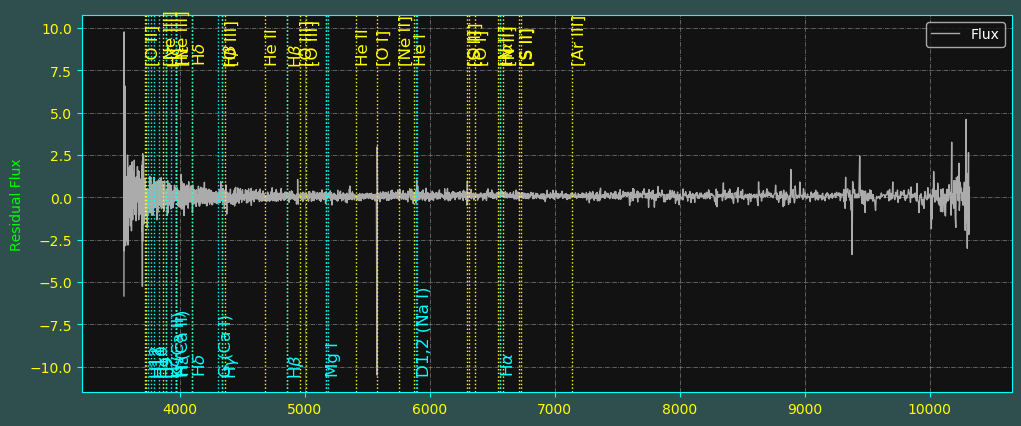

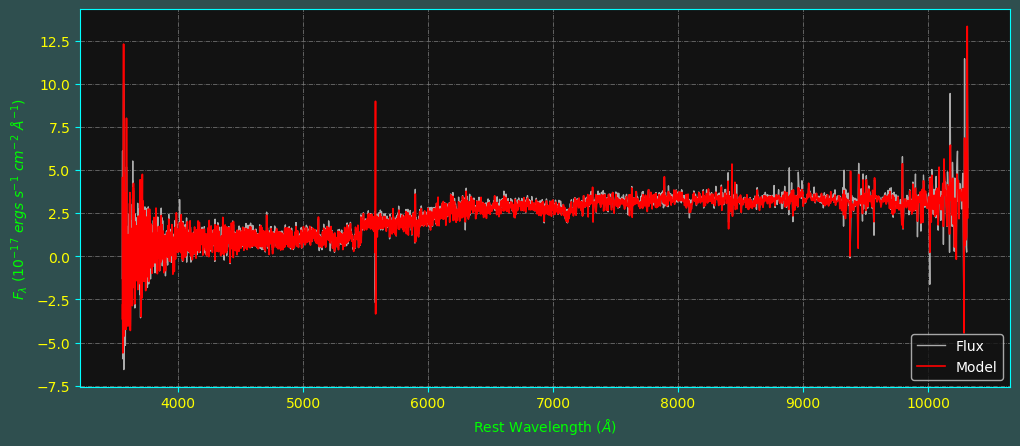

In [24]:
# Plot the residual
l = 10.0**dr16['loglam'][l16]
spec.sp_client._plotSpec(l, resid, bands='flux', ylabel='Residual Flux')

# Overplot the spectra
spec.sp_client._plotSpec(l, dr16['flux'][l16], model=dr9['flux'][l9], mark_lines='')

<a class="anchor" id="performance"></a>
## Data Caching and Performance

The default SDSS DR16 data are pre-processed and cached on SSD disks for faster performance, however all SDSS data releases are available.  When a context for an earlier dataset is specified, the data are extracted from the FITS files on the backend and returned in the same format as the cached data.  This introduces some overhead in the processing leading to slower performance of the service but allowing for greater data availability on limited hardware.

If an identifier does not resolve to a spectrum in the given context, other data releases within the survey will automatically be searched for a match.  This is meant to allow some level of flexibility in use of identifiers. Note that this only applies when the '*default*' context or most recent data release is given, specifying an earlier release will restrict the data to be found in that release or not at all.

<a class="anchor" id="viz"></a>

---
# Visualization

<a class="anchor" id="static_plot"></a>

## Static Spectrum Plot

For single spectra we provide a simple `plot()` method to display the spectrum.  This takes either an identifier (in which case the spectrum is retrieved automatically) or a spectrum object and will display a plot directly which makes is convenient for use in notebooks.  There are a number of options for controlling the plot appearance:

                rest_frame - Whether or not to plot the spectra in the
                             rest-frame  (def: True)
                         z - Redshift value (def: None)
                      xlim - Set the xrange of the plot
                      ylim - Set the yrange of the plot
    
                     bands - A comma-delimited string of which bands to plot,
                             a combination of 'flux,model,sky,ivar'
                mark_lines - Which lines to mark.  No lines marked if None or
                             an empty string, otherwise one of 'em|abs|all|both'
                      grid - Plot grid lines (def: True)
                      dark - Dark-mode plot colors (def: True)
                  em_lines - List of emission lines to plot.  If not given,
                             all the lines in the default list will be plotted.
                 abs_lines - Lines of absorption lines to plot.  If not given,
                             all the lines in the default list will be plotted.
                 spec_args - Plotting kwargs for the spectrum
                model_args - Plotting kwargs for the model
                 ivar_args - Plotting kwargs for the ivar
                  sky_args - Plotting kwargs for the sky

For example, to plot a spectrum from an identifier:

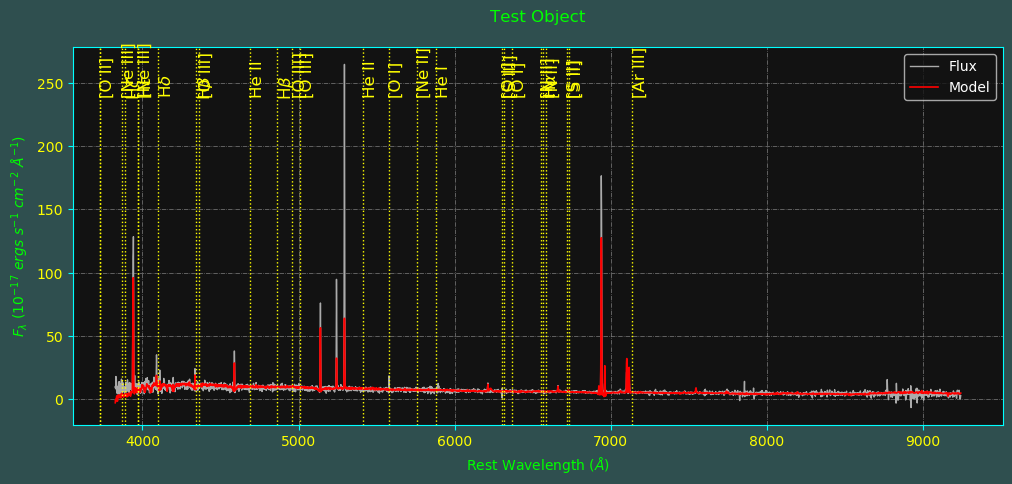

In [25]:
# Create a spectrum ID list for the plot
id_list = spec.query(30.0, 1.0, 25.0, out='', constraint='limit 200')
spec.plot(id_list[2], title='Test Object', figsize=(10,4),bands='flux,model', mark_lines='e')

The above plot uses the 'dark' mode option and marks only the emission lines in the spectrum.  In the next example we plot the data directly using the default 'light' mode theme, marking both absorption and emission lines:

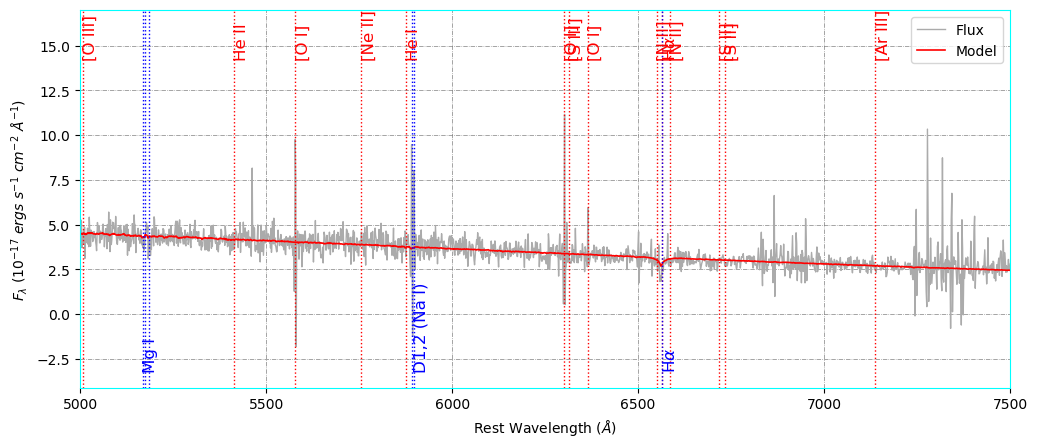

In [26]:
# Plot using a retrieved spectrum
spec.plot(data[7], figsize=(10,5), dark=False, xlim=(5000,7500))

Details of other plotting options can be found in the API documentation [link needed here]

<a class="anchor" id="preview_plot"></a>
## Preview Plot

Preview images of all spectra have been pre-computed for fast retrieval or use within user interfaces.  The `preview()` method can be used to retrieve a PNG image given a spectrum identifier.

 Type: <class 'PIL.PngImagePlugin.PngImageFile'>
object of type 'PngImageFile' has no len()
-----------
CPU times: user 41.3 ms, sys: 3.19 ms, total: 44.5 ms
Wall time: 46.9 ms


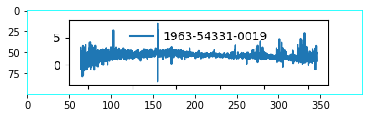

In [27]:
%%time

preview_png = spec.preview(2210146812474530816)
info(preview_png)
plt.imshow(preview_png)

<a class="anchor" id="grid_plot"></a>
## Grid Preview Plot

Another convenience function is the `plotGrid()` method to retrieve a grid of preview images for a list of spectra.  The user can specify the X and Y dimensions of the grid as well as a 'page' number to paginate the list that may be longer than the grid size.  In this case, the grid is generated on the server and returns a PNG image for display.

 Type: <class 'PIL.PngImagePlugin.PngImageFile'>
object of type 'PngImageFile' has no len()
-----------


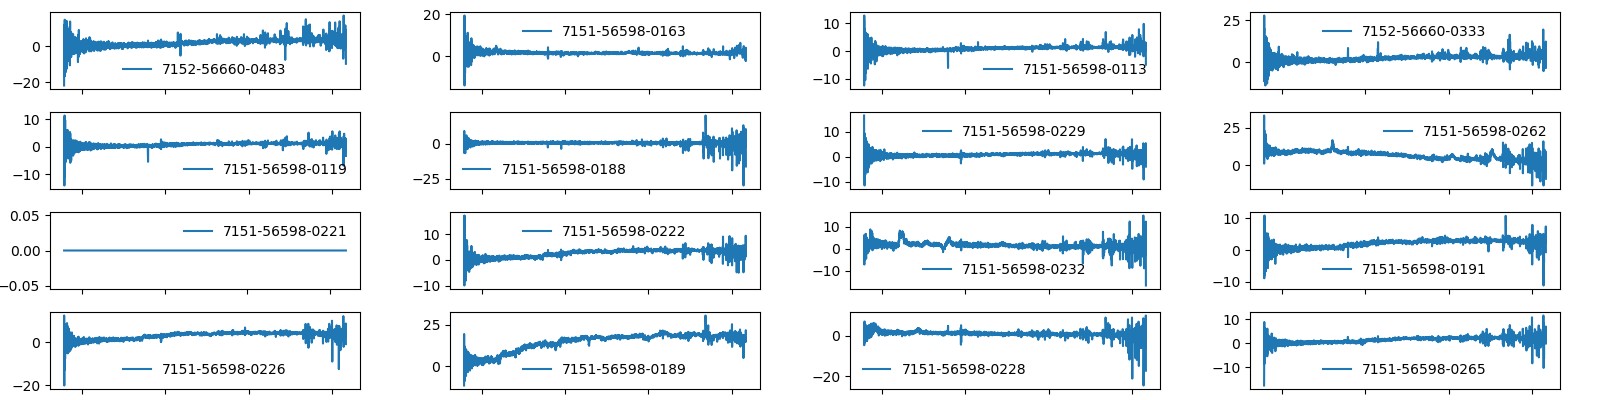

CPU times: user 88.4 ms, sys: 6.02 ms, total: 94.4 ms
Wall time: 169 ms


In [28]:
%%time

grid_png = spec.plotGrid(id_list, 4, 4, page=3, fmt='png')
info(grid_png)
display(grid_png)

Finer control over the display size can be had by using the 'fmt="raw"' option to retrieve the image bytes directly.  This allows the user to specify the display size by creating the image on the client side.

 Type: <class 'bytes'>
  Len: 107138
'bytes' object has no attribute 'shape'
-----------


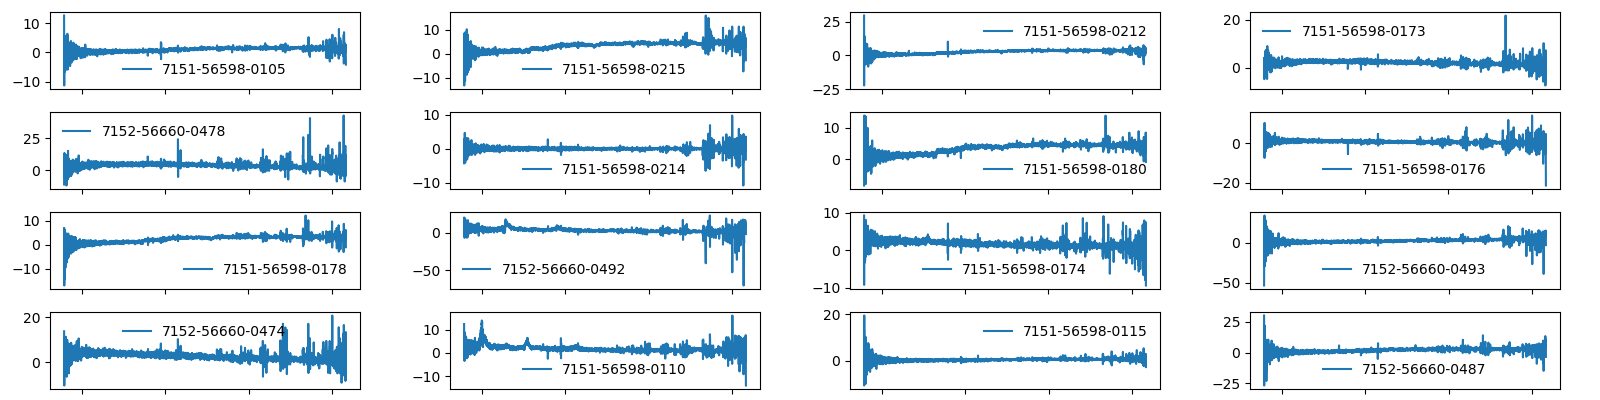

CPU times: user 16.3 ms, sys: 4.21 ms, total: 20.5 ms
Wall time: 97.4 ms


In [29]:
%%time

grid_png = spec.plotGrid(id_list, 4, 4, page=2, fmt='raw')
info(grid_png)
display(Image(grid_png, format='png', width=800, height=800, unconfined=True))

<a class="anchor" id="stacked_image"></a>
## Stacked Image Plot

A stacked image can be creating by assembling the flux vectors of each spectrum as rows in a 2-D image.  The data will automatically be aligned to a common wavelength grid and padded, meaning that spectral features within an identifier list will line up in the image.  The image is created in the same order as the identifier list allowing a list sorted by e.g. redshift to be displayed using that same sorting method.  The 'scale' parameter can be used to adjust the image size and any matplotlib colormap can be added.

 Type: <class 'PIL.PngImagePlugin.PngImageFile'>
object of type 'PngImageFile' has no len()
-----------


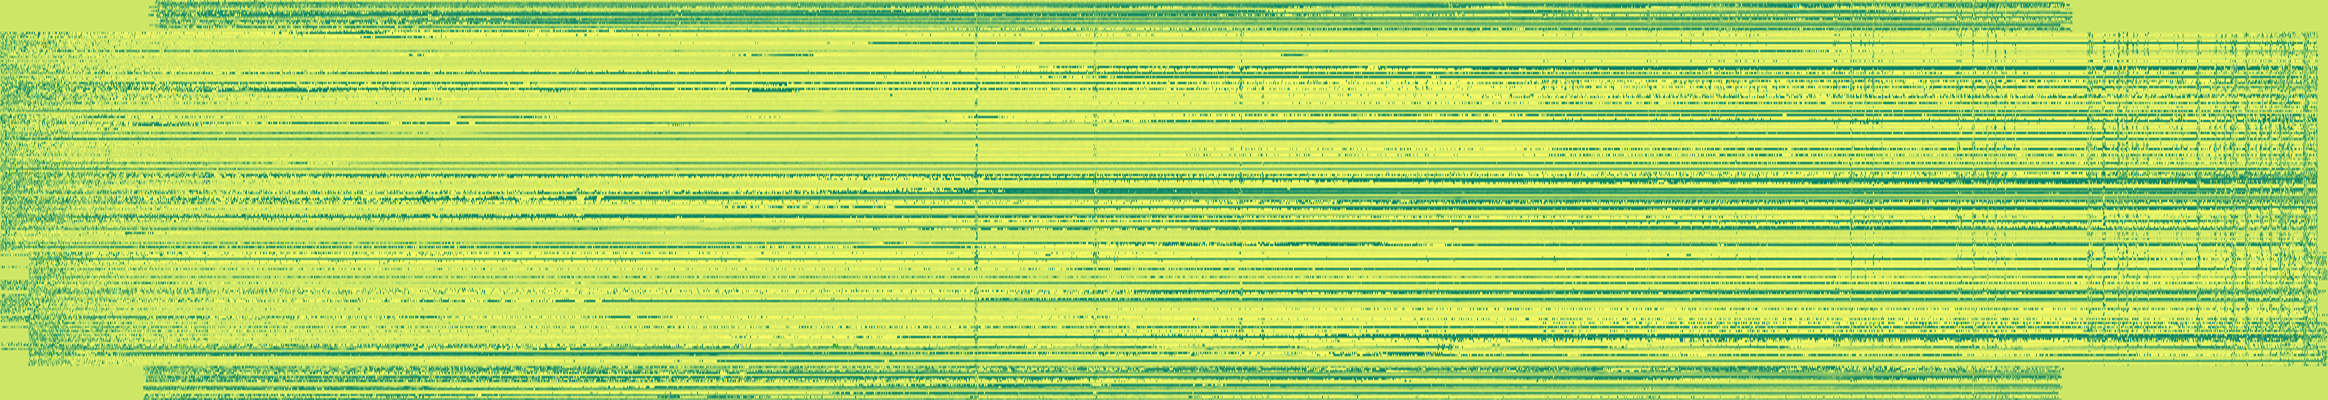

CPU times: user 654 ms, sys: 16.6 ms, total: 671 ms
Wall time: 1.55 s


In [30]:
%%time

stack_png = spec.stackedImage(id_list, scale=(0.5,2.0), cmap='summer', fmt='png')
info(stack_png)
display(stack_png)

Finer control over the display size can be had by using the 'fmt="raw"' option to retrieve the image bytes directly.  This allows the user to specify the display size by creating the image on the client side.

In [ ]:
%%time

stack_png = spec.stackedImage(id_list, scale=(0.2,4.0), cmap='summer', fmt='raw')
info(stack_png)
display(Image(stack_png, format='png', width=800, height=400, unconfined=True))

 Type: <class 'bytes'>
  Len: 932398
'bytes' object has no attribute 'shape'
-----------


<a class="anchor" id="utility"></a>
----
# Utility Methods

### Convert to Spectrum1D 

Given a Numpy array, convert it to a Spectrum1D object:

In [ ]:
spec1d = spec.to_Spectrum1D(data[4])
info(spec1d)

### Convert to Pandas DataFrame

Given a Numpy array, convert it to a Pandas DataFrame object:

In [ ]:
df = spec.to_pandas(data[4])
info(df)

### Convert to Astropy Table

Given a Numpy array, convert it to an Astropy Table object:

In [ ]:
tab = spec.to_table(data[4])
info(tab)

-----

In [ ]:
end_time = time.time()
print('Notebook run time: %.3g sec' % (end_time - start_time))